In [2]:
from glob import glob
from os.path import join
import pandas as pd
from scipy.stats import norm
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from scipy import stats

In [41]:
# Which run to use as a reference; set to None to use the one initially intended to be the reference.
REFERENCE_ROW_INDEX = 1

# Set this to the appropriate directory
base_path = './coverage_warm_starts_rerun//M_64/'

# Which model name to plot. Use "ARM" to analyse all ARM models.
model_name = 'occ_det'

coverage_runs = glob(join(base_path, '*', '*.pkl'))
model_names = [x.split('/')[-2] for x in coverage_runs]

rel_names = [model_name] if model_name != 'ARM' else [x for x in model_names if x not in ['occ_det', 'tennis', 'microcredit', 'potus']]

In [42]:
df = pd.DataFrame({'filename': coverage_runs, 'model_name': model_names})

# Drop the test models
df = df[~df['model_name'].str.contains('test')]

In [43]:

def compute_z_scores(loaded, reference_row_index=None, n_subset=None):
    
    if n_subset is not None:
        # Pick only the first n_subset
        loaded = loaded.iloc[:n_subset]
    
    if reference_row_index is not None:
        # Change reference
        reference_row = loaded.iloc[reference_row_index]
        loaded = loaded.copy()
                
        other_rows = loaded.loc[[x for x in loaded.index if x != reference_row.name]].copy()
        
        # This is pretty dumb -- better way?
        other_rows['reference_means'] = other_rows['reference_means'].apply(lambda _: reference_row['means'])
        other_rows['reference_freq_sds'] = other_rows['freq_sds'].apply(lambda _: reference_row['freq_sds'])
                
        loaded = other_rows
    
    z_scores = loaded.apply(
        lambda row: (row['means'] - row['reference_means']) / np.sqrt(
            row['reference_freq_sds']**2 + row['freq_sds']**2),
        axis=1)
    
    # Make them an array
    z_array = np.stack(z_scores.values)
    
    return z_array

def evaluate_z_scores(z_array, crit_prob=0.025):

    z_crit = norm.ppf(crit_prob)
    within_interval = np.abs(z_array) < np.abs(z_crit)
    within_ratio = within_interval.mean()
    
    return within_ratio

In [44]:
# Load the actual pickled results
df['loaded'] = df['filename'].apply(pd.read_pickle)

In [45]:
# Show some example data
df['loaded'].iloc[0].head()

,means,seed,freq_sds,newton_step_norm,scipy_opt_result,reference_means,reference_freq_sds,M,reference_newton_step_norm,reference_scipy_opt_result
0,"[5.9157796, -0.5543941, 0.36644948, 0.3843652,...",1000,"[0.006278170471453372, 0.011911594065872605, 0...",0.000000,"{'x': [5.9157796, -0.5543941, 0.36644948, 0.38...","[5.926037066720059, -0.5842364606894948, 0.374...","[0.006933493544069244, 0.01253902807450893, 0....",64,0.000002,"{'x': [5.926037, -0.58423644, 0.37423164, 0.39..."
1,"[5.9232297, -0.58279026, 0.3757099, 0.4135722,...",1001,"[0.0061925925720968675, 0.012143838513395068, ...",0.000005,"{'x': [5.9232297, -0.58279026, 0.3757099, 0.41...","[5.926037066720059, -0.5842364606894948, 0.374...","[0.006933493544069244, 0.01253902807450893, 0....",64,0.000002,"{'x': [5.926037, -0.58423644, 0.37423164, 0.39..."
2,"[5.923813, -0.5794337, 0.3772701, 0.4116608, -...",1002,"[0.006125596245577935, 0.012365704537414748, 0...",0.000000,"{'x': [5.923813, -0.5794337, 0.3772701, 0.4116...","[5.926037066720059, -0.5842364606894948, 0.374...","[0.006933493544069244, 0.01253902807450893, 0....",64,0.000002,"{'x': [5.926037, -0.58423644, 0.37423164, 0.39..."
3,"[5.928267, -0.6326322, 0.37404153, 0.40084413,...",1003,"[0.006380391842933137, 0.013376107441757282, 0...",0.000000,"{'x': [5.928267, -0.6326322, 0.37404153, 0.400...","[5.926037066720059, -0.5842364606894948, 0.374...","[0.006933493544069244, 0.01253902807450893, 0....",64,0.000002,"{'x': [5.926037, -0.58423644, 0.37423164, 0.39..."
4,"[5.916812, -0.5816739, 0.3633206, 0.3936959, -...",1004,"[0.006219462075086494, 0.01218610838978289, 0....",0.000000,"{'x': [5.916812, -0.5816739, 0.3633206, 0.3936...","[5.926037066720059, -0.5842364606894948, 0.374...","[0.006933493544069244, 0.01253902807450893, 0....",64,0.000002,"{'x': [5.926037, -0.58423644, 0.37423164, 0.39..."


A bit of explanation here: the field "loaded" now contains the rerun information. The column "means" lists the means for each rerun. The column "reference_means" lists the means for the reference run whose confidence interval we wish to evalute. And the column "reference_freq_sds" contains the estimated frequentist standard deviations.

In [46]:
# Look at the worst final Newton step for all reruns
df['worst_newton_step_norm'] = df['loaded'].apply(lambda x: x['newton_step_norm'].max())

<AxesSubplot:>

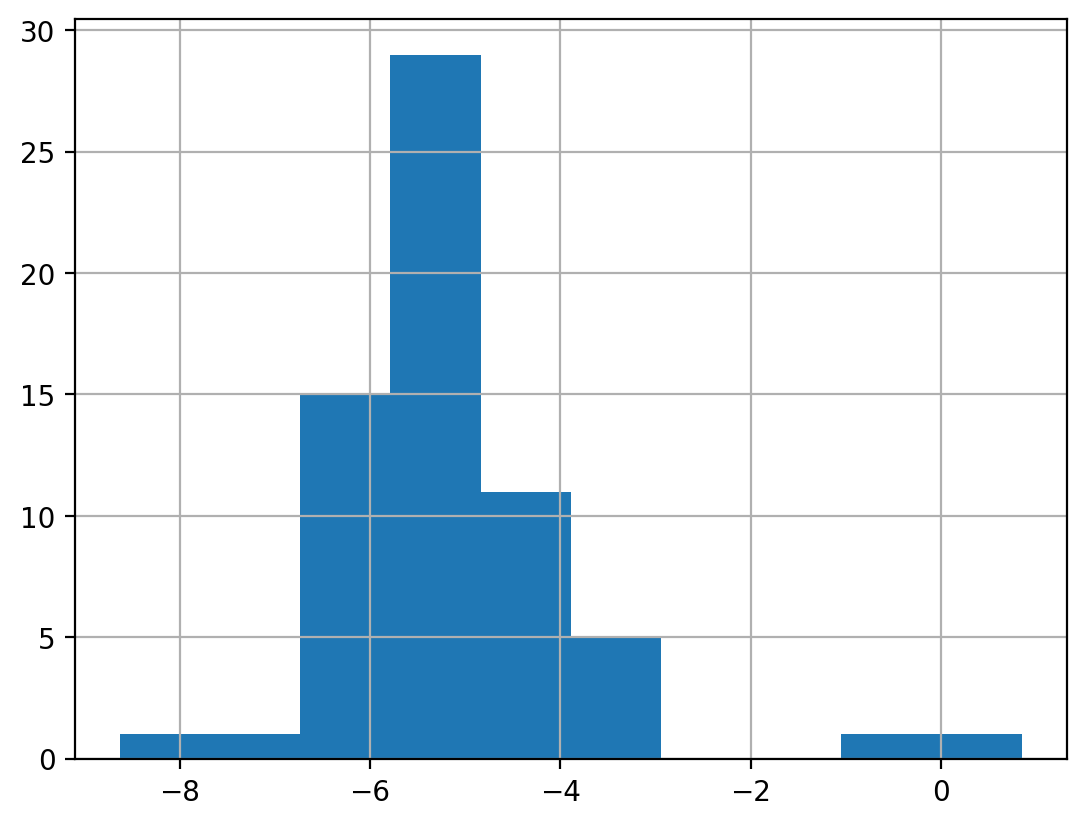

In [47]:
# Check convergence
np.log10(df['worst_newton_step_norm']).hist()

In [48]:
# Drop models that likely didn't converge
print('Dropping:')
print(df[df['worst_newton_step_norm'] > 10**(-2)]['model_name'])

problematic =  df[df['worst_newton_step_norm'] >= 10**(-2)].copy()

df = df[df['worst_newton_step_norm'] < 10**(-2)].copy()

Dropping:
1        mesquite
32    earn_height
Name: model_name, dtype: object


In [49]:
# Also check scipy convergence message

def compute_frac_non_convergent(loaded):
    
    #return np.mean(loaded['scipy_opt_result'].apply(lambda x: x.status) != 0)
    return np.mean(loaded['scipy_opt_result'].apply(lambda x: x.message) != 'Optimization terminated successfully.')

def drop_non_converged(loaded):
    
    #return loaded[loaded['scipy_opt_result'].apply(lambda x: x.status) == 0]
    return loaded[loaded['scipy_opt_result'].apply(lambda x: x.message) == 'Optimization terminated successfully.']

# Check scipy convergence statuses
df['frac_not_converged'] = df['loaded'].apply(compute_frac_non_convergent)

# Drop these
df['loaded'] = df['loaded'].apply(drop_non_converged)

# Subset to the model names desired
df = df[df['model_name'].isin(rel_names)]

In [50]:
df['frac_not_converged'].max()

0.0

In [51]:
df['z_scores'] = df['loaded'].apply(partial(compute_z_scores, reference_row_index=REFERENCE_ROW_INDEX))

In [52]:
df['frac_within'] = df['z_scores'].apply(evaluate_z_scores)

In [53]:
df['M'] = df['loaded'].apply(lambda x: x['M'].iloc[0])

df['M'].value_counts()

64    1
Name: M, dtype: int64

In [54]:
# 95% should lie within.
df[['model_name', 'M', 'frac_within']].sort_values('frac_within').head()

,model_name,M,frac_within
2,occ_det,64,0.94415


In [55]:
# Turn the z-scores into "p-values"
df['p_vals'] = df['z_scores'].apply(norm.cdf)

In [56]:
# Make them into one long vector
all_p_vals = np.concatenate(df['p_vals'].apply(lambda x: x.reshape(-1)).values)

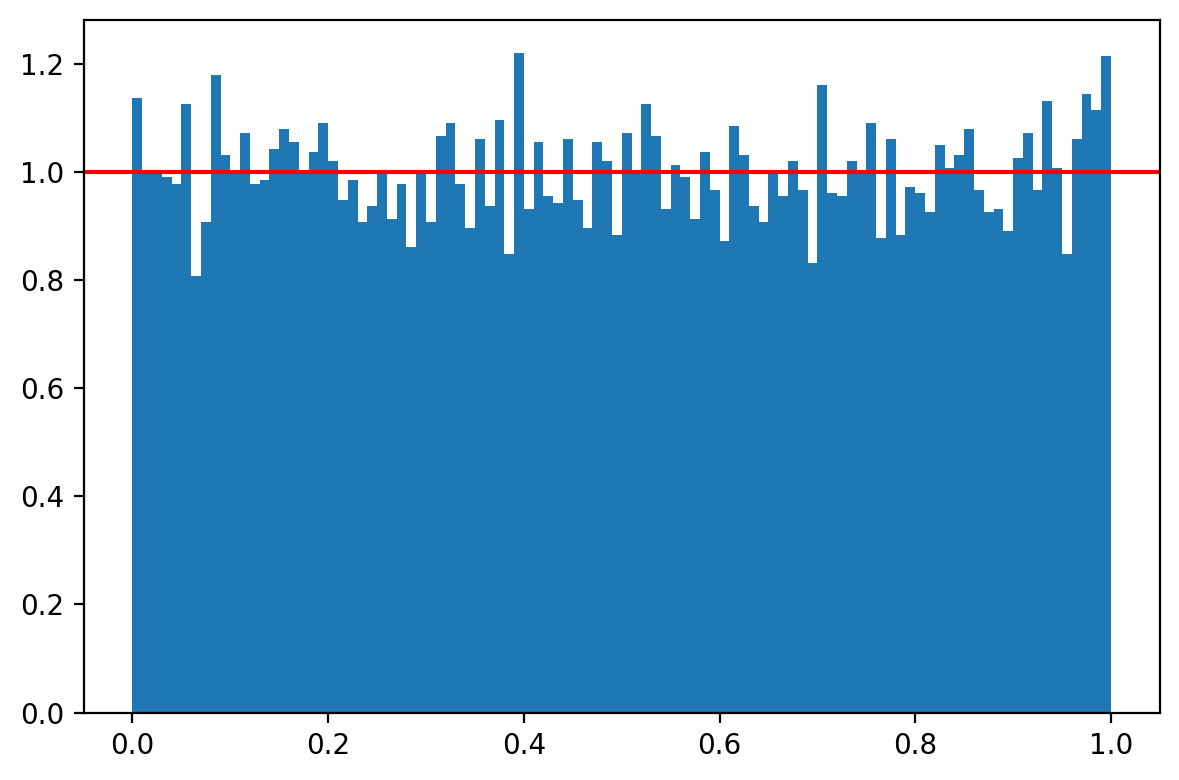

In [57]:
# Plot a histogram
f, ax = plt.subplots(1, 1)

_ = ax.hist(all_p_vals, density=True, bins=100)
ax.axhline(1, color='r')

f.set_size_inches(6, 4)
f.tight_layout()

#plt.savefig(f'overall_coverage_M={df["M"].iloc[0]}.png', dpi=300)

In [23]:
# We can do a test to check for uniformity
stats.kstest(all_p_vals, stats.uniform(loc=0.0, scale=1.0).cdf)

KstestResult(statistic=0.028221108646495463, pvalue=1.9238964412202313e-140)

In [24]:
# We can do the same test by model
df.groupby('model_name').apply(
    lambda df: stats.kstest(df['p_vals'].iloc[0].reshape(-1), stats.uniform(loc=0.0, scale=1.0).cdf)[1]).sort_values().head(10)

model_name
pilots               8.452207e-68
election88           5.619895e-60
electric_1b          3.462718e-49
electric_1a          5.488384e-47
electric_1c          3.434915e-45
election88_full      5.457469e-29
radon_no_pool        5.848871e-27
radon_no_pool_chr    5.848871e-27
radon_vary_si        1.347362e-22
radon_inter_vary     1.152713e-20
dtype: float64

In [25]:
# Make sure this works as intended -- this one should not be rejected
stats.kstest(norm.cdf(np.random.randn(1000)), stats.uniform(loc=0., scale=1.).cdf)

KstestResult(statistic=0.01808055592578317, pvalue=0.8932925690074733)

In [27]:
# Pick out a model of interest
model_to_check = 'electric_1c'

model_p_vals = df[df['model_name'] == model_to_check]['p_vals'].iloc[0]
model_p_vals.shape

(99, 114)

In [28]:
df[df['model_name'] == model_to_check]

,filename,model_name,loaded,worst_newton_step_norm,frac_not_converged,z_scores,frac_within,M,p_vals
3,./coverage_warm_starts_rerun//M_64/electric_1c...,electric_1c,...,0.000008,0.0,"[[-0.3768941, -0.5106951, -0.12618683, -1.0298...",0.943913,64,"[[0.35312615807389536, 0.3047822862448726, 0.4..."


In [29]:
df[df['model_name'] == model_to_check].iloc[0]['loaded'].head()

,means,seed,freq_sds,newton_step_norm,scipy_opt_result,reference_means,reference_freq_sds,M,reference_newton_step_norm,reference_scipy_opt_result
0,"[-1.7274795, 0.17858513, 0.3301883, 0.20273158...",1000,"[0.03203842669531779, 0.07051467392988708, 0.0...",0.000000e+00,"{'x': [-1.7274795, 0.17858513, 0.3301883, 0.20...","[-1.6694232259649444, 0.26620441629193214, 0.4...","[0.0428550489074541, 0.06913757459770507, 0.07...",64,0.000005,"{'x': [-1.6694232, 0.26620442, 0.41813135, 0.3..."
1,"[-1.7094156, 0.22830757, 0.34277105, 0.3000041...",1001,"[0.03564637158149606, 0.0671349136019012, 0.06...",1.996698e-07,"{'x': [-1.7094156, 0.22830757, 0.34277105, 0.3...","[-1.6694232259649444, 0.26620441629193214, 0.4...","[0.0428550489074541, 0.06913757459770507, 0.07...",64,0.000005,"{'x': [-1.6694232, 0.26620442, 0.41813135, 0.3..."
2,"[-1.7114935, 0.23173116, 0.3699855, 0.27442285...",1002,"[0.0375505720769561, 0.06965941678208837, 0.07...",2.501178e-07,"{'x': [-1.7114935, 0.23173116, 0.3699855, 0.27...","[-1.6694232259649444, 0.26620441629193214, 0.4...","[0.0428550489074541, 0.06913757459770507, 0.07...",64,0.000005,"{'x': [-1.6694232, 0.26620442, 0.41813135, 0.3..."
3,"[-1.6657454, 0.31810498, 0.4039909, 0.28923938...",1003,"[0.03542339156564061, 0.060431134935319, 0.057...",4.786629e-08,"{'x': [-1.6657454, 0.31810498, 0.4039909, 0.28...","[-1.6694232259649444, 0.26620441629193214, 0.4...","[0.0428550489074541, 0.06913757459770507, 0.07...",64,0.000005,"{'x': [-1.6694232, 0.26620442, 0.41813135, 0.3..."
4,"[-1.7196349, 0.20902537, 0.3347117, 0.26475886...",1004,"[0.035964693573674524, 0.07512528614692432, 0....",0.000000e+00,"{'x': [-1.7196349, 0.20902537, 0.3347117, 0.26...","[-1.6694232259649444, 0.26620441629193214, 0.4...","[0.0428550489074541, 0.06913757459770507, 0.07...",64,0.000005,"{'x': [-1.6694232, 0.26620442, 0.41813135, 0.3..."


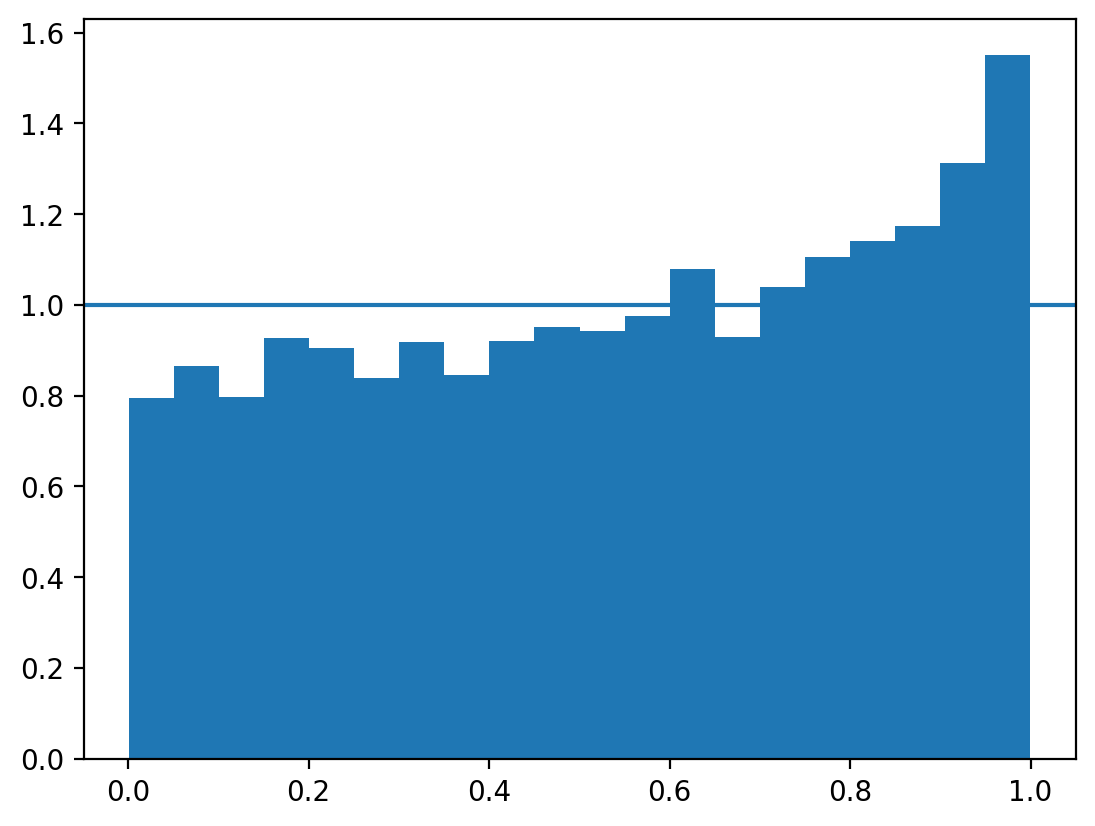

In [30]:
plt.hist(model_p_vals.reshape(-1), density=True, bins=20)
plt.axhline(1.)

# plt.savefig(f'{model_to_check}_coverage_M={df["M"].iloc[0]}.png', dpi=300)

In [31]:
model_z_scores = df[df['model_name'] == model_to_check]['z_scores'].iloc[0].reshape(-1)

In [32]:
exclude_problematic = False

if exclude_problematic:
    problematic = ['earnings_latin_square', 'earn_height']
else:
    problematic = []

flat_z_scores = np.concatenate(df[~df['model_name'].isin(problematic)]['z_scores'].apply(lambda x: x.reshape(-1)).values)

flat_z_scores.shape

(202356,)

In [33]:
all_p_vals = np.concatenate(
    df[~df['model_name'].isin(problematic)]['p_vals'].apply(
    lambda x: x.reshape(-1)).values)

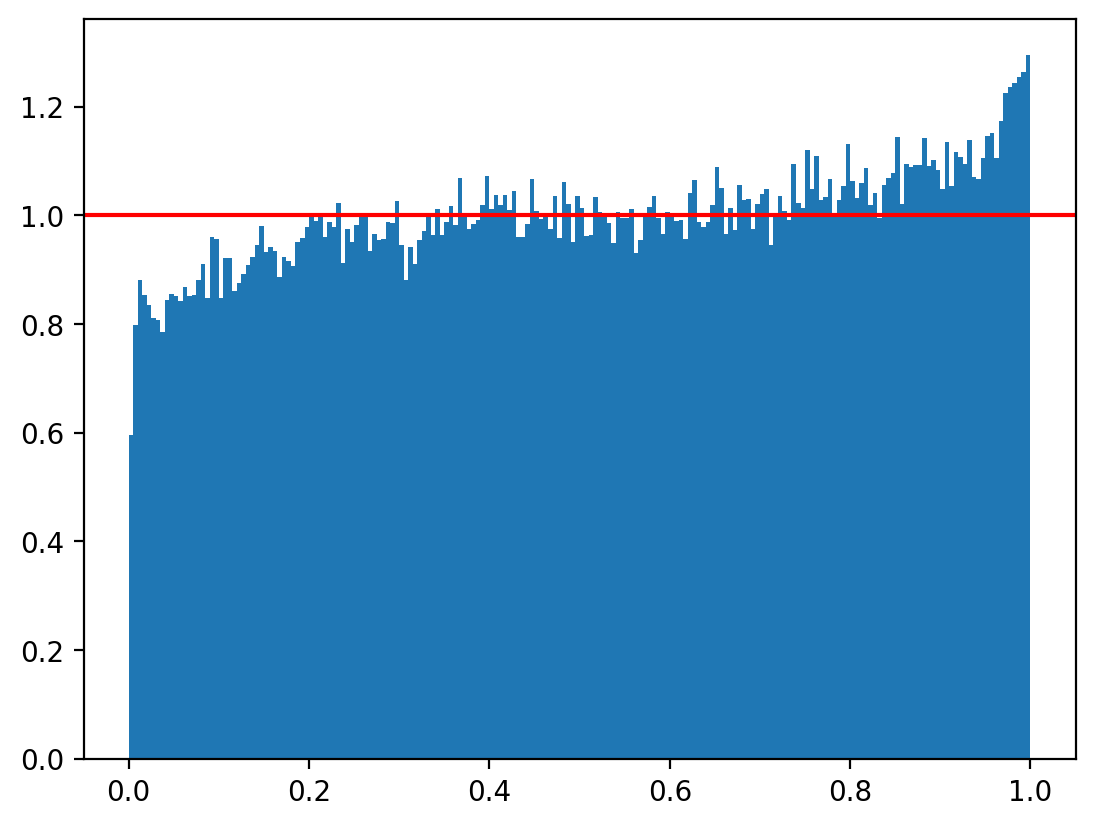

In [34]:
plt.hist(all_p_vals, density=True, bins=200)
plt.axhline(1, color='r')

(array([2.0000e+01, 3.0200e+02, 3.0790e+03, 1.3371e+04, 2.8635e+04,
        3.1572e+04, 1.7355e+04, 4.9270e+03, 6.8600e+02, 5.3000e+01]),
 array([0.32607288, 0.35995312, 0.39383336, 0.4277136 , 0.46159384,
        0.49547408, 0.52935432, 0.56323455, 0.59711479, 0.63099503,
        0.66487527]),
 <BarContainer object of 10 artists>)

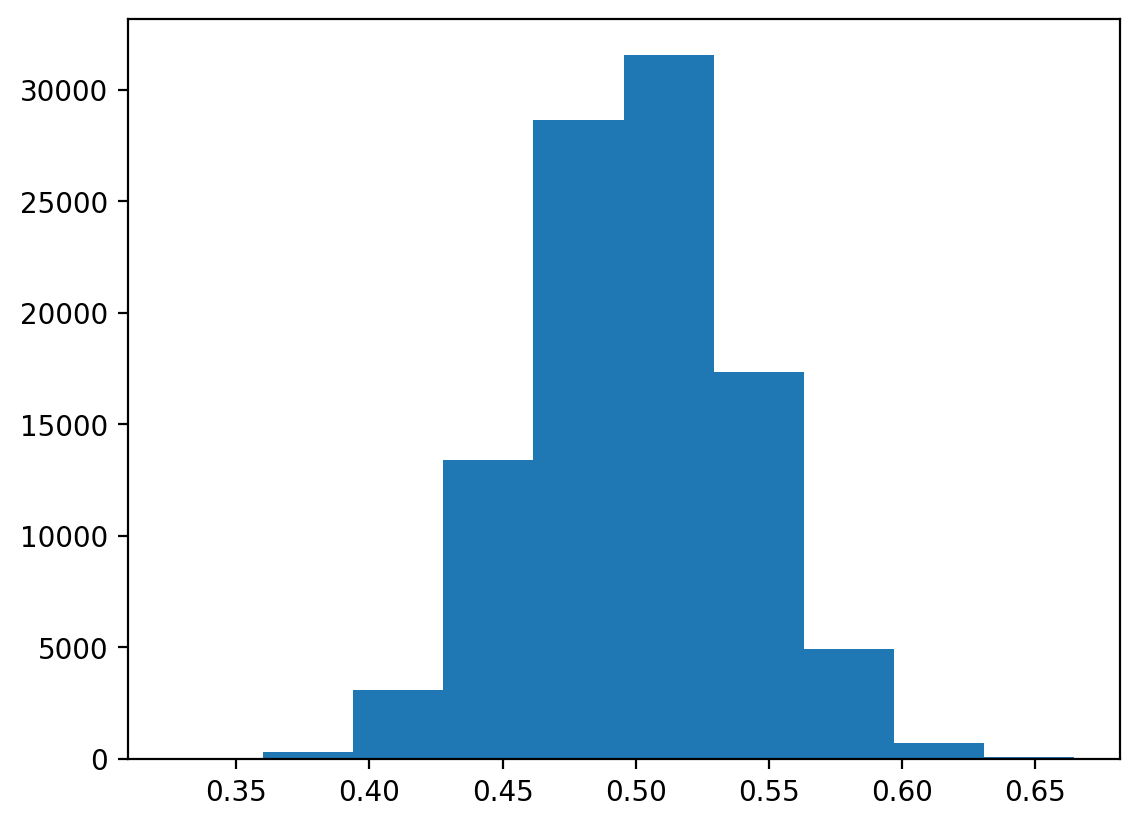

In [35]:
# A few experiments -- what happens if we had a lower variance in z?
# In this case, our intervals would be too conservative -- what would that look like?
plt.hist(norm.cdf(norm.rvs(scale=.1, size=100000)))

(array([11884., 11127., 10638., 10293.,  9964.,  9849.,  9623.,  9253.,
         8908.,  8461.]),
 array([4.11772311e-06, 1.00002454e-01, 2.00000790e-01, 2.99999125e-01,
        3.99997461e-01, 4.99995797e-01, 5.99994133e-01, 6.99992469e-01,
        7.99990805e-01, 8.99989141e-01, 9.99987477e-01]),
 <BarContainer object of 10 artists>)

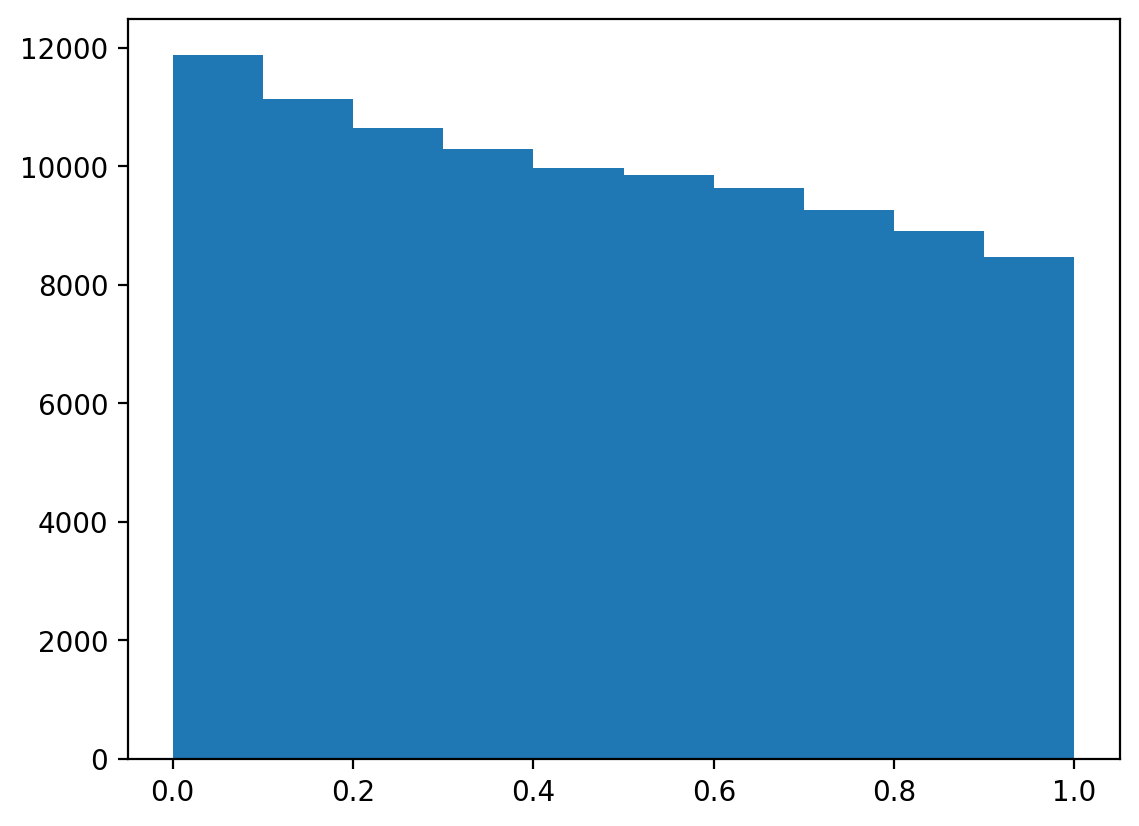

In [36]:
# What about a systematic bias?
plt.hist(norm.cdf(norm.rvs(loc=-0.1, scale=1., size=100000)))

(array([44887.,  1813.,  1247.,  1105.,   998.,   972.,  1038.,  1226.,
         1714., 45000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

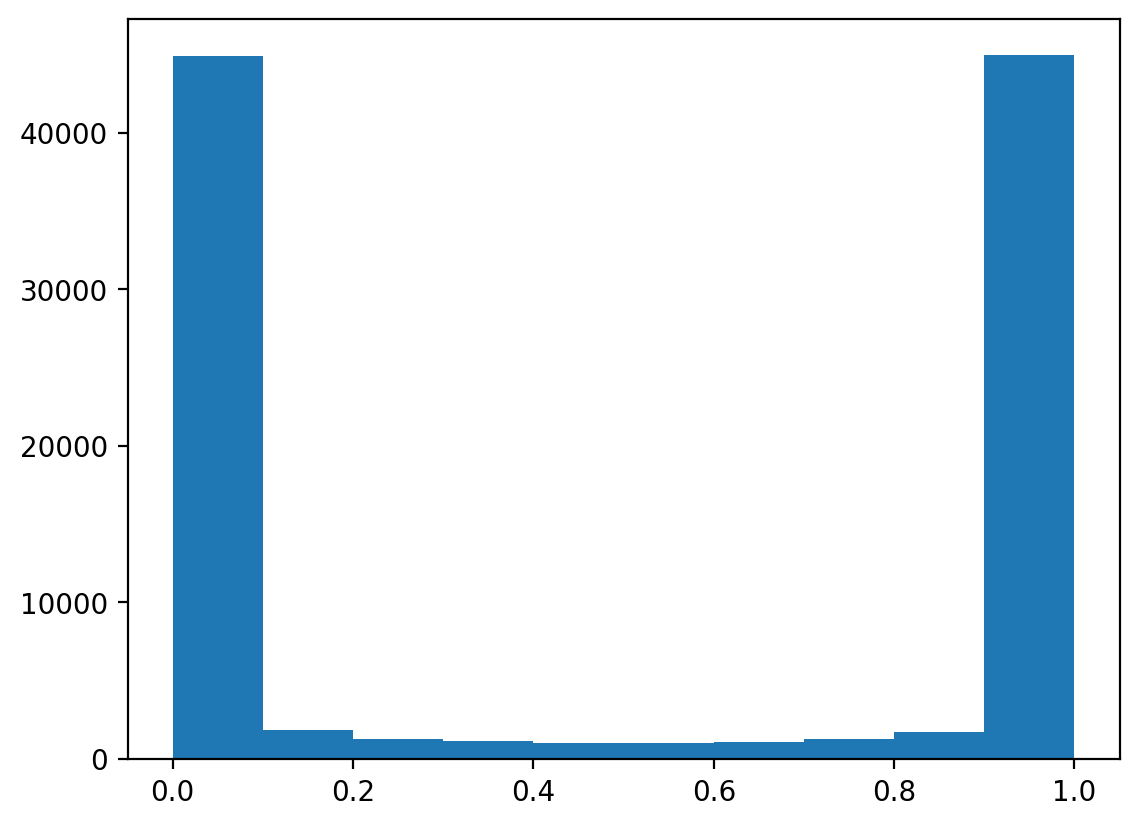

In [37]:
# And what about if our intervals were too narrow?
plt.hist(norm.cdf(norm.rvs(scale=10., size=100000)))

In [38]:
# Lastly, we can take a look at which z-score is most outlying
df['min_z_score'] = df['z_scores'].apply(lambda x: x.min())

In [39]:
df.sort_values('min_z_score').head(10)

,filename,model_name,loaded,worst_newton_step_norm,frac_not_converged,z_scores,frac_within,M,p_vals,min_z_score
31,./coverage_warm_starts_rerun//M_64/pilots/cove...,pilots,...,6.435392e-06,0.0,"[[2.1741607, -1.211309, -0.8943357, -0.1335909...",0.904932,64,"[[0.9851534663731191, 0.11288850876157508, 0.1...",-4.020880
35,./coverage_warm_starts_rerun//M_64/radon_group...,radon_group_chr,...,1.095370e-06,0.0,"[[-0.45361146, 0.47122532, 0.17289919, 0.19852...",0.948822,64,"[[0.325054250647757, 0.6812600808890215, 0.568...",-3.852541
39,./coverage_warm_starts_rerun//M_64/radon_group...,radon_group,...,1.095370e-06,0.0,"[[-0.45361146, 0.47122532, 0.17289919, 0.19852...",0.948822,64,"[[0.325054250647757, 0.6812600808890215, 0.568...",-3.852541
26,./coverage_warm_starts_rerun//M_64/election88_...,election88_full,...,7.136316e-07,0.0,"[[0.9486847, -0.72235376, -1.2385343, 1.098400...",0.933851,64,"[[0.8286094991116382, 0.23503850521496644, 0.1...",-3.808394
10,./coverage_warm_starts_rerun//M_64/earnings_la...,earnings_latin_square,...,2.510900e-06,0.0,"[[0.3319593, 0.0001772494, 1.2529637, -0.99097...",0.931269,64,"[[0.630040006797193, 0.5000707122793507, 0.894...",-3.784222
37,./coverage_warm_starts_rerun//M_64/radon_vary_...,radon_vary_si,...,3.172809e-07,0.0,"[[-0.13040718, 0.6026381, 0.3919791, -0.272400...",0.946360,64,"[[0.4481221414156525, 0.7266252741501616, 0.65...",-3.534252
58,./coverage_warm_starts_rerun//M_64/radon_inter...,radon_inter_vary,...,7.750959e-07,0.0,"[[-1.1403514, -0.43344852, -0.10115576, -1.082...",0.951274,64,"[[0.1270699628097755, 0.332344477760118, 0.459...",-3.526796
5,./coverage_warm_starts_rerun//M_64/electric_1b...,electric_1b,...,8.824146e-07,0.0,"[[-0.48137265, -1.701538, -0.54601866, 0.10973...",0.940494,64,"[[0.3151258341039478, 0.0444210073884129, 0.29...",-3.516741
0,./coverage_warm_starts_rerun//M_64/mesquite_va...,mesquite_vas,...,5.873550e-06,0.0,"[[-0.8448393, 1.6693243, -1.147756, -2.8393533...",0.953283,64,"[[0.19910029145135993, 0.9524734344369215, 0.1...",-3.496743
20,./coverage_warm_starts_rerun//M_64/radon_inter...,radon_intercept,...,5.992765e-07,0.0,"[[-0.16854858, -0.10067496, -0.38519773, -0.59...",0.946511,64,"[[0.43307586291628924, 0.4599042458697701, 0.3...",-3.467009


In [40]:
worst_one = df.sort_values('min_z_score').iloc[0]

In [77]:
worst_one

filename              ./coverage_warm_starts_rerun//M_64/occ_det/cov...
model_name                                                      occ_det
loaded                                                              ...
frac_not_converged                                                  0.0
z_scores              [[0.2697131, 0.51187086, -1.505637, 0.57947135...
frac_within                                                     0.94415
M                                                                    64
p_vals                [[0.6063095106582751, 0.6956293036065494, 0.06...
min_z_score                                                   -7.176533
Name: 2, dtype: object